<a href="https://colab.research.google.com/github/buzaev-fedor/project-from-ml-course/blob/master/%22Project_3_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Данные взяты с Kaggle https://www.kaggle.com/kazanova/sentiment140. Нужно предсказать по твиту, позитивный или негативный. 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Download dataframe

In [ ]:
columns_name = ["target", "ids", "date", "flag", "user", "text"]
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/training.1600000.processed.noemoticon.csv", encoding = 'ISO-8859-1', names = columns_name)

In [ ]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


### Preprocessing 

#### Delete unnecessary data

In [ ]:
df['flag'].value_counts()

NO_QUERY    1600000
Name: flag, dtype: int64

In [ ]:
del df['flag']
del df['ids']
del df['date']

In [ ]:
df.head()

,target,user,text
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,scotthamilton,is upset that he can't update his Facebook by ...
2,0,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,ElleCTF,my whole body feels itchy and like its on fire
4,0,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df['target'].value_counts()

4    800000
0    800000
Name: target, dtype: int64

In [ ]:
df['target'] = df['target'].map({0:0, 4:1})

1    800000
0    800000
Name: target, dtype: int64
0 = negative, 1 = positive


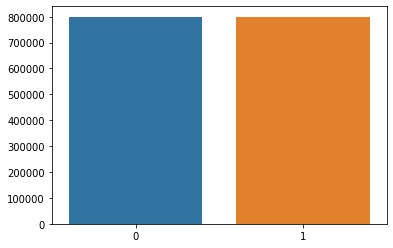

In [ ]:
print(df["target"].value_counts())
sns.barplot(df["target"].value_counts().index, df["target"].value_counts().values)
print('0 = negative, 1 = positive')

#### Lower the text and replace emojis

In [ ]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [ ]:
import string
# realization preprocessing
def preprocess(doc):
    # lower the text
    doc = doc.lower()
    # remove punctuation, spaces, etc.
    for p in string.punctuation + string.whitespace:
        doc = doc.replace(p, ' ')
    # remove extra spaces, merge back
    doc = doc.strip()
    doc = ' '.join([w for w in doc.split(' ') if w != ''])
    for emoji in emojis.keys():
        doc = doc.replace(emoji, "EMOJI" + emojis[emoji])
    return doc

In [ ]:
for colname in df.select_dtypes(include = np.object).columns:
    df[colname] = df[colname].map(preprocess)
df.head()

,target,user,text
0,0,thespecialone,switchfoot http twitpic com 2y1zl awww that s ...
1,0,scotthamilton,is upset that he can t update his facebook by ...
2,0,mattycus,kenichan i dived many times for the ball manag...
3,0,ellectf,my whole body feels itchy and like its on fire
4,0,karoli,nationwideclass no it s not behaving at all i ...


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head()

,target,user,text
0,0,irulz,working in office need to work on presentation...
1,0,emiliebromley,headache
2,0,140lover,hahaha i just had a little coffee making error...
3,0,tiff frm da twn,good morning tweeter fam i m sick again i hope...
4,1,nannapei,desgraced yea for babies


### Train-test split

#### Take 50/50 data for balance negative and positive

In [ ]:
negative_df = df[df['target'] == 0][:150000]
negative_df

,target,user,text
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,scotthamilton,is upset that he can't update his Facebook by ...
2,0,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,ElleCTF,my whole body feels itchy and like its on fire
4,0,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...
149995,0,MissEmilyGreen,@SusieCornelius box games!!!!!! Blind Date was...
149996,0,sfasweetheart05,I dont wanna leave!!!
149997,0,wonderwall1101,@jordanknight I'm a Japanese fan living in Tai...
149998,0,azmiulul,tidak menemukan cd album 'off the beaten path'...


In [ ]:
positive_df = df[df['target'] == 1][:150000]
positive_df

,target,user,text
800000,1,ersle,I LOVE @Health4UandPets u guys r the best!!
800001,1,becca210,im meeting up with one of my besties tonight! ...
800002,1,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,katarinka,Being sick can be really cheap when it hurts t...
800004,1,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone
...,...,...,...
949995,1,Broooooke_,just got back from Demi's house...so much fun!...
949996,1,explosivityy,@IFUSEEKPEPPER YAY ! i'm sure you'll be amazin...
949997,1,iSushix,Twooooo in the morning. Insomnia.
949998,1,bytespc,@suziperry http://twitpic.com/57wc7 - Now they...


In [ ]:
df_limited = pd.DataFrame

In [ ]:
df_limited = negative_df.append(positive_df, ignore_index=True)
df_limited = df_limited.sample(frac=1).reset_index(drop=True)
df_limited.head()

,target,user,text
0,0,LouieveeA,wheressss my bff
1,0,ManiaPoison,No one wants to hit up PR mayne.
2,0,omfgimdel,A bee just chased me
3,0,Pinktinktash,bored outta my teeny lil brain so gonna watch ...
4,0,brehbeauty,making breakfast[cinnamon toast crunch(:] i ha...


In [ ]:
df_limited['target'].value_counts()

1    150000
0    150000
Name: target, dtype: int64

In [ ]:
y = df_limited['target'].map({True: 1, False: 0}).values
y

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
df_limited.drop(['target'], axis = 1, inplace=True)
df_limited.head()

,user,text
0,LouieveeA,wheressss my bff
1,ManiaPoison,No one wants to hit up PR mayne.
2,omfgimdel,A bee just chased me
3,Pinktinktash,bored outta my teeny lil brain so gonna watch ...
4,brehbeauty,making breakfast[cinnamon toast crunch(:] i ha...


#### Train-test split with sklearn

In [ ]:
X = df_limited

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y)

In [ ]:
X_train.shape, X_test.shape

((240000, 2), (60000, 2))

In [ ]:
y_train.shape, y_test.shape

((240000,), (60000,))

### Using TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range=(1, 2)).fit(df['text'])

X_train_vectors = vectorizer.transform(X_train['text'])
X_test_vectors = vectorizer.transform(X_test['text'])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
X_train_vectors.shape, X_test_vectors.shape

((240000, 5481996), (60000, 5481996))

In [ ]:
num = 65
X_train_vectors[num].data

array([0.33708043, 0.13547304, 0.35209078, 0.16897945, 0.40131195,
       0.20025706, 0.40961818, 0.35953508, 0.14902521, 0.38960496,
       0.20807362])

In [ ]:
vectorizer.inverse_transform(X_train_vectors[num])[0][np.argsort(X_train_vectors[num].data)]

array(['thanks', 'did', 'pretty', 'lucky', 'catch', 'thanks pretty',
       'pretty lucky', 'frogboy229', 'catch did', 'lucky catch',
       'frogboy229 thanks'], dtype='<U125')

### kNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3).fit(X_train_vectors, y_train)

In [ ]:
predicts = knn.predict((X_test_vectors))
print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

           0       0.86      0.11      0.19     30000
           1       0.52      0.98      0.68     30000

    accuracy                           0.54     60000
   macro avg       0.69      0.54      0.44     60000
weighted avg       0.69      0.54      0.44     60000



### Logistic regression

In [ ]:
lr = LogisticRegression(penalty = 'l2', C = 2, max_iter = 1000, n_jobs=-1).fit(X_train_vectors, y_train)

In [ ]:
predicts = lr.predict((X_test_vectors))
print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

           0       0.80      0.75      0.77     30000
           1       0.77      0.81      0.79     30000

    accuracy                           0.78     60000
   macro avg       0.78      0.78      0.78     60000
weighted avg       0.78      0.78      0.78     60000



### Naive Bayes

#### Multinomial NB

In [ ]:
clf = MultinomialNB(alpha = 2.0689655172413794).fit(X_train_vectors, y_train)

In [ ]:
predicts = clf.predict((X_test_vectors))
print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77     30000
           1       0.78      0.74      0.76     30000

    accuracy                           0.77     60000
   macro avg       0.77      0.77      0.77     60000
weighted avg       0.77      0.77      0.77     60000



#### Bernoulli NB

In [ ]:
clf = BernoulliNB(alpha = 2.0689655172413794).fit(X_train_vectors, y_train)

In [ ]:
predicts = clf.predict((X_test_vectors))
print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

           0       0.74      0.81      0.78     30000
           1       0.79      0.71      0.75     30000

    accuracy                           0.76     60000
   macro avg       0.77      0.76      0.76     60000
weighted avg       0.77      0.76      0.76     60000



#### ComplementNB

In [ ]:
clf = ComplementNB(alpha = 2.0689655172413794).fit(X_train_vectors, y_train)

In [ ]:
predicts = clf.predict((X_test_vectors))
print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77     30000
           1       0.78      0.73      0.76     30000

    accuracy                           0.76     60000
   macro avg       0.76      0.76      0.76     60000
weighted avg       0.76      0.76      0.76     60000

